# Code generation and Execution

In [1]:
%matplotlib inline

### setup llm client

In [2]:
# Cell 1: Load .env and set up OpenAI
import os
from dotenv import load_dotenv
import openai

load_dotenv()

client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

### setup code generation function

In [3]:
# Cell 2: Generate and save code (cleaned)
def get_code_from_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an AI coder. Provide only executable Python code — no markdown or explanation."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()

prompt = """Give me code to download the file from
https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2.bz2
Decompress the .bz2 file and use the `eccodes` Python package to list all available keys in the first GRIB message.
Only print keys, do not access unknown keys directly. Return python code only."""

code = get_code_from_llm(prompt)

# Remove Markdown-style code fences if present
if code.startswith("```"):
    code = "\n".join(code.splitlines()[1:-1])

with open("download_dwd.py", "w") as f:
    f.write(code)

print("Generated and saved code:")
print(code)

Generated and saved code:
import requests
import bz2
import eccodes

# Download the file
url = "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2.bz2"
response = requests.get(url)

# Save the .bz2 file
with open("data.grib2.bz2", "wb") as f:
    f.write(response.content)

# Decompress the .bz2 file
with open("data.grib2", "wb") as f:
    f.write(bz2.decompress(open("data.grib2.bz2", "rb").read()))

# List keys in the first GRIB message
with open("data.grib2", "rb") as f:
    with eccodes.Codec(f) as gid:
        gid.seek(0)  # Go to the start of the file
        while gid.read() is not None:
            keys = gid.keys()
            print(keys)
            break  # Only print for the first message


In [4]:
# Check outputs
!ls -ltrh

total 16M
-rwxrwxrwx 1 rolan rolan  25K May 10 07:37 dawid_graph.py
-rwxrwxrwx 1 rolan rolan 405K May 10 07:37 2_langgraph_get_forecast.ipynb
drwxrwxrwx 1 rolan rolan  512 May 10 07:37 downloads
-rwxrwxrwx 1 rolan rolan 1.1M May 10 11:26 temp
-rwxrwxrwx 1 rolan rolan 875K May 10 13:37 icon-d2_germany.grib2.bz2
-rwxrwxrwx 1 rolan rolan 1.1M May 10 13:37 icon-d2_germany.grib2
-rwxrwxrwx 1 rolan rolan 875K May 10 13:37 data.grib2.bz2
-rwxrwxrwx 1 rolan rolan 1.1M May 10 13:37 data.grib2
-rwxrwxrwx 1 rolan rolan 875K May 10 13:45 weather_data.grib2.bz2
-rwxrwxrwx 1 rolan rolan 1.1M May 10 13:45 weather_data.grib2
-rwxrwxrwx 1 rolan rolan 1.1M May 10 13:45 icon-d2_germany_2025051000.grib2
-rwxrwxrwx 1 rolan rolan 1.3K May 10 13:45 llm_generated.py
-rwxrwxrwx 1 rolan rolan  767 May 10 13:45 download_clat_clon_D2.py
-rwxrwxrwx 1 rolan rolan 1.1M May 10 13:45 clat.grib2
-rwxrwxrwx 1 rolan rolan 1.1M May 10 13:45 clon.grib2
-rwxrwxrwx 1 rolan rolan 1.9M May 10 13:45 t2m_template.png
-rwxrwxrwx 

### Execute generated code


In [5]:
import traceback

try:
    exec(open("download_dwd.py").read())
except Exception as e:
    print("❌ Error during execution of download_dwd.py:")
    traceback.print_exc()

❌ Error during execution of download_dwd.py:


Traceback (most recent call last):
  File "/tmp/ipykernel_13415/2130651293.py", line 4, in <module>
    exec(open("download_dwd.py").read())
  File "<string>", line 19, in <module>
AttributeError: module 'eccodes' has no attribute 'Codec'


## prepare functions for code generation and execution

In [6]:
import traceback
import openai
import os

client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

def get_code_from_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an AI coder. Output ONLY Python code that can be saved directly. No markdown formatting, no explanations."},
            {"role": "user", "content": prompt}
        ]
    )
    code = response.choices[0].message.content.strip()
    # Strip markdown fences if present
    if code.startswith("```"):
        code = "\n".join(code.splitlines()[1:-1])
    return code

def run_generated_code(code, filename="llm_generated.py"):
    with open(filename, "w") as f:
        f.write(code)
    print(f"\n🔧 Saved to {filename}")
    try:
        print("\n▶️ Running code...\n")
        exec_globals = {}
        exec(open(filename).read(), exec_globals)
        return True, None
    except Exception as e:
        tb = traceback.format_exc()
        print("❌ Error during execution:\n", tb)
        return False, tb


### manual loop for feedback

In [7]:
prompt = """Download the file from
https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/t_2m/icon-d2_germany_icosahedral_single-level_2025051000_000_2d_t_2m.grib2.bz2
Decompress the .bz2 file and print basic info about the GRIB file using the eccodes library.
Use: from eccodes import codes_grib_new_from_file, codes_get, codes_release
List the available GRIB keys in the first message and print a few safe ones like shortName, level."""

MAX_TRIES = 5
current_prompt = prompt

for attempt in range(1, MAX_TRIES + 1):
    print(f"\n=== Attempt {attempt} ===")
    code = get_code_from_llm(current_prompt)
    success, error = run_generated_code(code)
    if success:
        print("\n✅ Code executed successfully.")
        break
    else:
        # Append traceback to the prompt for next try
        current_prompt = prompt + f"\n\nThe previous attempt failed with this error:\n{error}\n\nPlease fix the problem and provide corrected code."



=== Attempt 1 ===

🔧 Saved to llm_generated.py

▶️ Running code...

❌ Error during execution:
 Traceback (most recent call last):
  File "/tmp/ipykernel_13415/425034271.py", line 28, in run_generated_code
    exec(open(filename).read(), exec_globals)
  File "<string>", line 29, in <module>
  File "/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/gribapi/gribapi.py", line 2013, in grib_get
    ktype = grib_get_native_type(msgid, key)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/gribapi/gribapi.py", line 1981, in grib_get_native_type
    GRIB_CHECK(err)
  File "/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/gribapi/gribapi.py", line 232, in GRIB_CHECK
    errors.raise_grib_error(errid)
  File "/home/rolan/all/ropy_wsl/lib/python3.12/site-packages/gribapi/errors.py", line 381, in raise_grib_error
    raise ERROR_MAP[errid](errid)
gribapi.errors.KeyValueNotFoundError: Key/value not found


=== Attempt 2 ===

🔧 Saved

### Testing some functions to give them as templates

In [8]:
from eccodes import codes_grib_new_from_file, codes_get, codes_release

filename = "data.grib2"
shortnames = set()

with open(filename, "rb") as f:
    while True:
        try:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            shortname = codes_get(gid, "shortName")
            if shortname not in shortnames:
                print("-", shortname)
                shortnames.add(shortname)
            codes_release(gid)
        except Exception as e:
            print("⚠️ Error reading GRIB message:", e)
            break

- 2t


## Execution Loop as Function

In [9]:
from IPython.display import display, Markdown

def llm_code_execution_loop(prompt, max_tries=5, filename="llm_generated.py"):
    """
    Repeatedly calls LLM to generate code and runs it, feeding back errors until it succeeds or max_tries is reached.

    Parameters:
    - prompt (str): The user prompt for the LLM.
    - max_tries (int): Maximum number of attempts.
    - filename (str): Filename to save the generated code.

    Returns:
    - (success, final_code): Tuple with success flag and final generated code.
    """
    current_prompt = prompt
    final_code = ""

    for attempt in range(1, max_tries + 1):
        print(f"\n=== Attempt {attempt} ===")
        code = get_code_from_llm(current_prompt)
        final_code = code  # save final code for return
        
        # Force main() call in notebooks if it's defined
        if "def main()" in code and "main()" not in code:
            final_code += "\n\nmain()\n"
    
        # ✅ Show generated code in a Markdown code block
        display(Markdown(f"```\n{code}\n```"))
    
        success, error = run_generated_code(code, filename=filename)
        if success:
            print(f"\n✅ Code in {filename} executed successfully.")
            return True, final_code
        else:
            current_prompt = prompt + f"\n\nThe last run failed with this error:\n{error}\n\nPlease fix and regenerate valid Python code."

    print(f"\n❌ Failed after {max_tries} attempts.")
    return False, final_code


### Testing on Download

In [10]:
prompt = """Download the files 
https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clat/icon-d2_germany_icosahedral_time-invariant_2025051000_000_0_clat.grib2.bz2 
and https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clon/icon-d2_germany_icosahedral_time-invariant_2025051000_000_0_clon.grib2.bz2. 
Decompress the .bz2 file save it as clon.grib2 and clat.grib2."""

success, final_code = llm_code_execution_loop(prompt, max_tries=5, filename="download_clat_clon_D2.py")



=== Attempt 1 ===


```
import requests
import bz2

urls = [
    "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clat/icon-d2_germany_icosahedral_time-invariant_2025051000_000_0_clat.grib2.bz2",
    "https://opendata.dwd.de/weather/nwp/icon-d2/grib/00/clon/icon-d2_germany_icosahedral_time-invariant_2025051000_000_0_clon.grib2.bz2"
]

filenames = ['clat.grib2.bz2', 'clon.grib2.bz2']

for url, filename in zip(urls, filenames):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

for filename in filenames:
    with bz2.BZ2File(filename, 'rb') as f:
        data = f.read()
    with open(filename[:-4], 'wb') as f:
        f.write(data)
```


🔧 Saved to download_clat_clon_D2.py

▶️ Running code...


✅ Code in download_clat_clon_D2.py executed successfully.


### Checking File Contents

In [11]:
from eccodes import codes_grib_new_from_file, codes_get, codes_get_array, codes_release
import numpy as np

def read_2t_from_data_grib2(filename="data.grib2"):
    with open(filename, "rb") as f:
        gid = codes_grib_new_from_file(f)
        if gid is None:
            print("No GRIB message found.")
            return None
        shortname = codes_get(gid, "shortName")
        print("shortName:", shortname)
        values = codes_get_array(gid, "values")
        codes_release(gid)
        return np.array(values)

t2m = read_2t_from_data_grib2()
print("✅ Loaded:", t2m.shape)
print("Min:", np.min(t2m), "Max:", np.max(t2m))

shortName: 2t
✅ Loaded: (542040,)
Min: 262.244873046875 Max: 9999.0


## Testing the Code Generation and Execution of Plotting ICON-D2

In [12]:
template = """
from eccodes import codes_grib_new_from_file, codes_get, codes_release

filename = "data.grib2"
shortnames = set()

with open(filename, "rb") as f:
    while True:
        try:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            shortname = codes_get(gid, "shortName")
            if shortname not in shortnames:
                print("-", shortname)
                shortnames.add(shortname)
            codes_release(gid)
        except Exception as e:
            print("⚠️ Error reading GRIB message:", e)
            break
"""

prompt = f"""The following template works:\n{template}\n\n
Now write a complete Python script using only `eccodes` to extract and plot temperature data:

- Read from three GRIB2 files:
  - `clat.grib2` contains latitude values (`shortName="tlat"`)
  - `clon.grib2` contains longitude values (`shortName="tlon"`)
  - `data.grib2` contains 2m temperature (`shortName="2t"`)

- For each file, find the message with the correct `shortName` and extract values using `codes_get_array`.
- Convert the temperature from Kelvin to Celsius.
- Filter out all temperature values outside the range [-10, 50] °C, and apply the same mask to lat/lon.
- Create a 2D scatter plot using `matplotlib`, with:
  - x = tlon
  - y = tlat
  - color = 2t
  - point size = 1
- Use `cartopy` to:
  - Add country borders
  - Add rivers
  - Add the land-sea mask as a visible black outline
- Include a colorbar scaled to the figure
- Save the resulting figure as `t2m.png`
- Output **only valid and executable Python code** (no markdown or explanation).
"""

success, final_code = llm_code_execution_loop(prompt, max_tries=5, filename="plot_dwd.py")


=== Attempt 1 ===


```
from eccodes import codes_grib_new_from_file, codes_get_array, codes_release
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def extract_values_from_grib(filename, shortname):
    values = []
    with open(filename, "rb") as f:
        while True:
            try:
                gid = codes_grib_new_from_file(f)
                if gid is None:
                    break
                if codes_get(gid, "shortName") == shortname:
                    values = codes_get_array(gid, "values")
                codes_release(gid)
            except Exception as e:
                break
    return values

tlat = extract_values_from_grib("clat.grib2", "tlat")
tlon = extract_values_from_grib("clon.grib2", "tlon")
temperature_k = extract_values_from_grib("data.grib2", "2t")

temperature_c = temperature_k - 273.15
mask = (temperature_c >= -10) & (temperature_c <= 50)
tlat_masked = tlat[mask]
tlon_masked = tlon[mask]
temperature_c_masked = temperature_c[mask]

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(tlon_masked, tlat_masked, c=temperature_c_masked, cmap='coolwarm', s=1, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND, edgecolor='black')
plt.colorbar(sc, label='Temperature (°C)', ax=ax)
ax.set_title('2m Temperature Scatter Plot')
plt.savefig('t2m.png', bbox_inches='tight')
plt.show()
```


🔧 Saved to plot_dwd.py

▶️ Running code...

❌ Error during execution:
 Traceback (most recent call last):
  File "/tmp/ipykernel_13415/425034271.py", line 28, in run_generated_code
    exec(open(filename).read(), exec_globals)
  File "<string>", line 26, in <module>
TypeError: unsupported operand type(s) for -: 'list' and 'float'


=== Attempt 2 ===


```
from eccodes import codes_grib_new_from_file, codes_get, codes_get_array, codes_release
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

files = ["clat.grib2", "clon.grib2", "data.grib2"]
latitudes = None
longitudes = None
temperatures = None

for filename in files:
    with open(filename, "rb") as f:
        while True:
            try:
                gid = codes_grib_new_from_file(f)
                if gid is None:
                    break
                shortname = codes_get(gid, "shortName")
                
                if shortname == "tlat":
                    latitudes = codes_get_array(gid, "latitudes")
                elif shortname == "tlon":
                    longitudes = codes_get_array(gid, "longitudes")
                elif shortname == "2t":
                    temperatures = codes_get_array(gid, "values")
                    temperatures = temperatures - 273.15  # Convert Kelvin to Celsius
                
                codes_release(gid)
            except Exception as e:
                print("⚠️ Error reading GRIB message:", e)
                break

# Filter temperature data
mask = (temperatures >= -10) & (temperatures <= 50)
latitudes = latitudes[mask]
longitudes = longitudes[mask]
temperatures = temperatures[mask]

# Plotting
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
scatter = plt.scatter(longitudes, latitudes, c=temperatures, cmap='coolwarm', s=1, transform=ccrs.PlateCarree())

# Adding features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

# Colorbar
cbar = plt.colorbar(scatter, orientation='vertical', pad=0.02, aspect=50)
cbar.set_label('Temperature (°C)')

# Save the figure
plt.title('2m Temperature')
plt.savefig('t2m.png', bbox_inches='tight')
plt.close()
```


🔧 Saved to plot_dwd.py

▶️ Running code...

⚠️ Error reading GRIB message: Key/value not found
⚠️ Error reading GRIB message: Key/value not found
❌ Error during execution:
 Traceback (most recent call last):
  File "/tmp/ipykernel_13415/425034271.py", line 28, in run_generated_code
    exec(open(filename).read(), exec_globals)
  File "<string>", line 36, in <module>
TypeError: 'NoneType' object is not subscriptable


=== Attempt 3 ===


```
from eccodes import codes_grib_new_from_file, codes_get_array, codes_release
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lat_file = "clat.grib2"
lon_file = "clon.grib2"
data_file = "data.grib2"

def extract_values(filename, short_name):
    with open(filename, "rb") as f:
        while True:
            try:
                gid = codes_grib_new_from_file(f)
                if gid is None:
                    break
                if codes_get(gid, "shortName") == short_name:
                    values = codes_get_array(gid, "values")
                    codes_release(gid)
                    return values
            except Exception:
                break
    return None

tlat = extract_values(lat_file, "tlat")
tlon = extract_values(lon_file, "tlon")
temperature = extract_values(data_file, "2t")

if tlat is not None and tlon is not None and temperature is not None:
    temperature_c = temperature - 273.15
    mask = (temperature_c >= -10) & (temperature_c <= 50)
    
    tlat_masked = tlat[mask]
    tlon_masked = tlon[mask]
    temperature_masked = temperature_c[mask]

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    scatter = ax.scatter(tlon_masked, tlat_masked, c=temperature_masked, cmap='coolwarm', s=1, transform=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN)

    plt.colorbar(scatter, ax=ax, orientation='vertical', label='Temperature (°C)')
    plt.title('2-Meter Temperature')
    plt.savefig('t2m.png', dpi=300)
    plt.show()
else:
    print("Error: Unable to extract one or more required datasets.")
```


🔧 Saved to plot_dwd.py

▶️ Running code...

Error: Unable to extract one or more required datasets.

✅ Code in plot_dwd.py executed successfully.


### Show Image, if generated

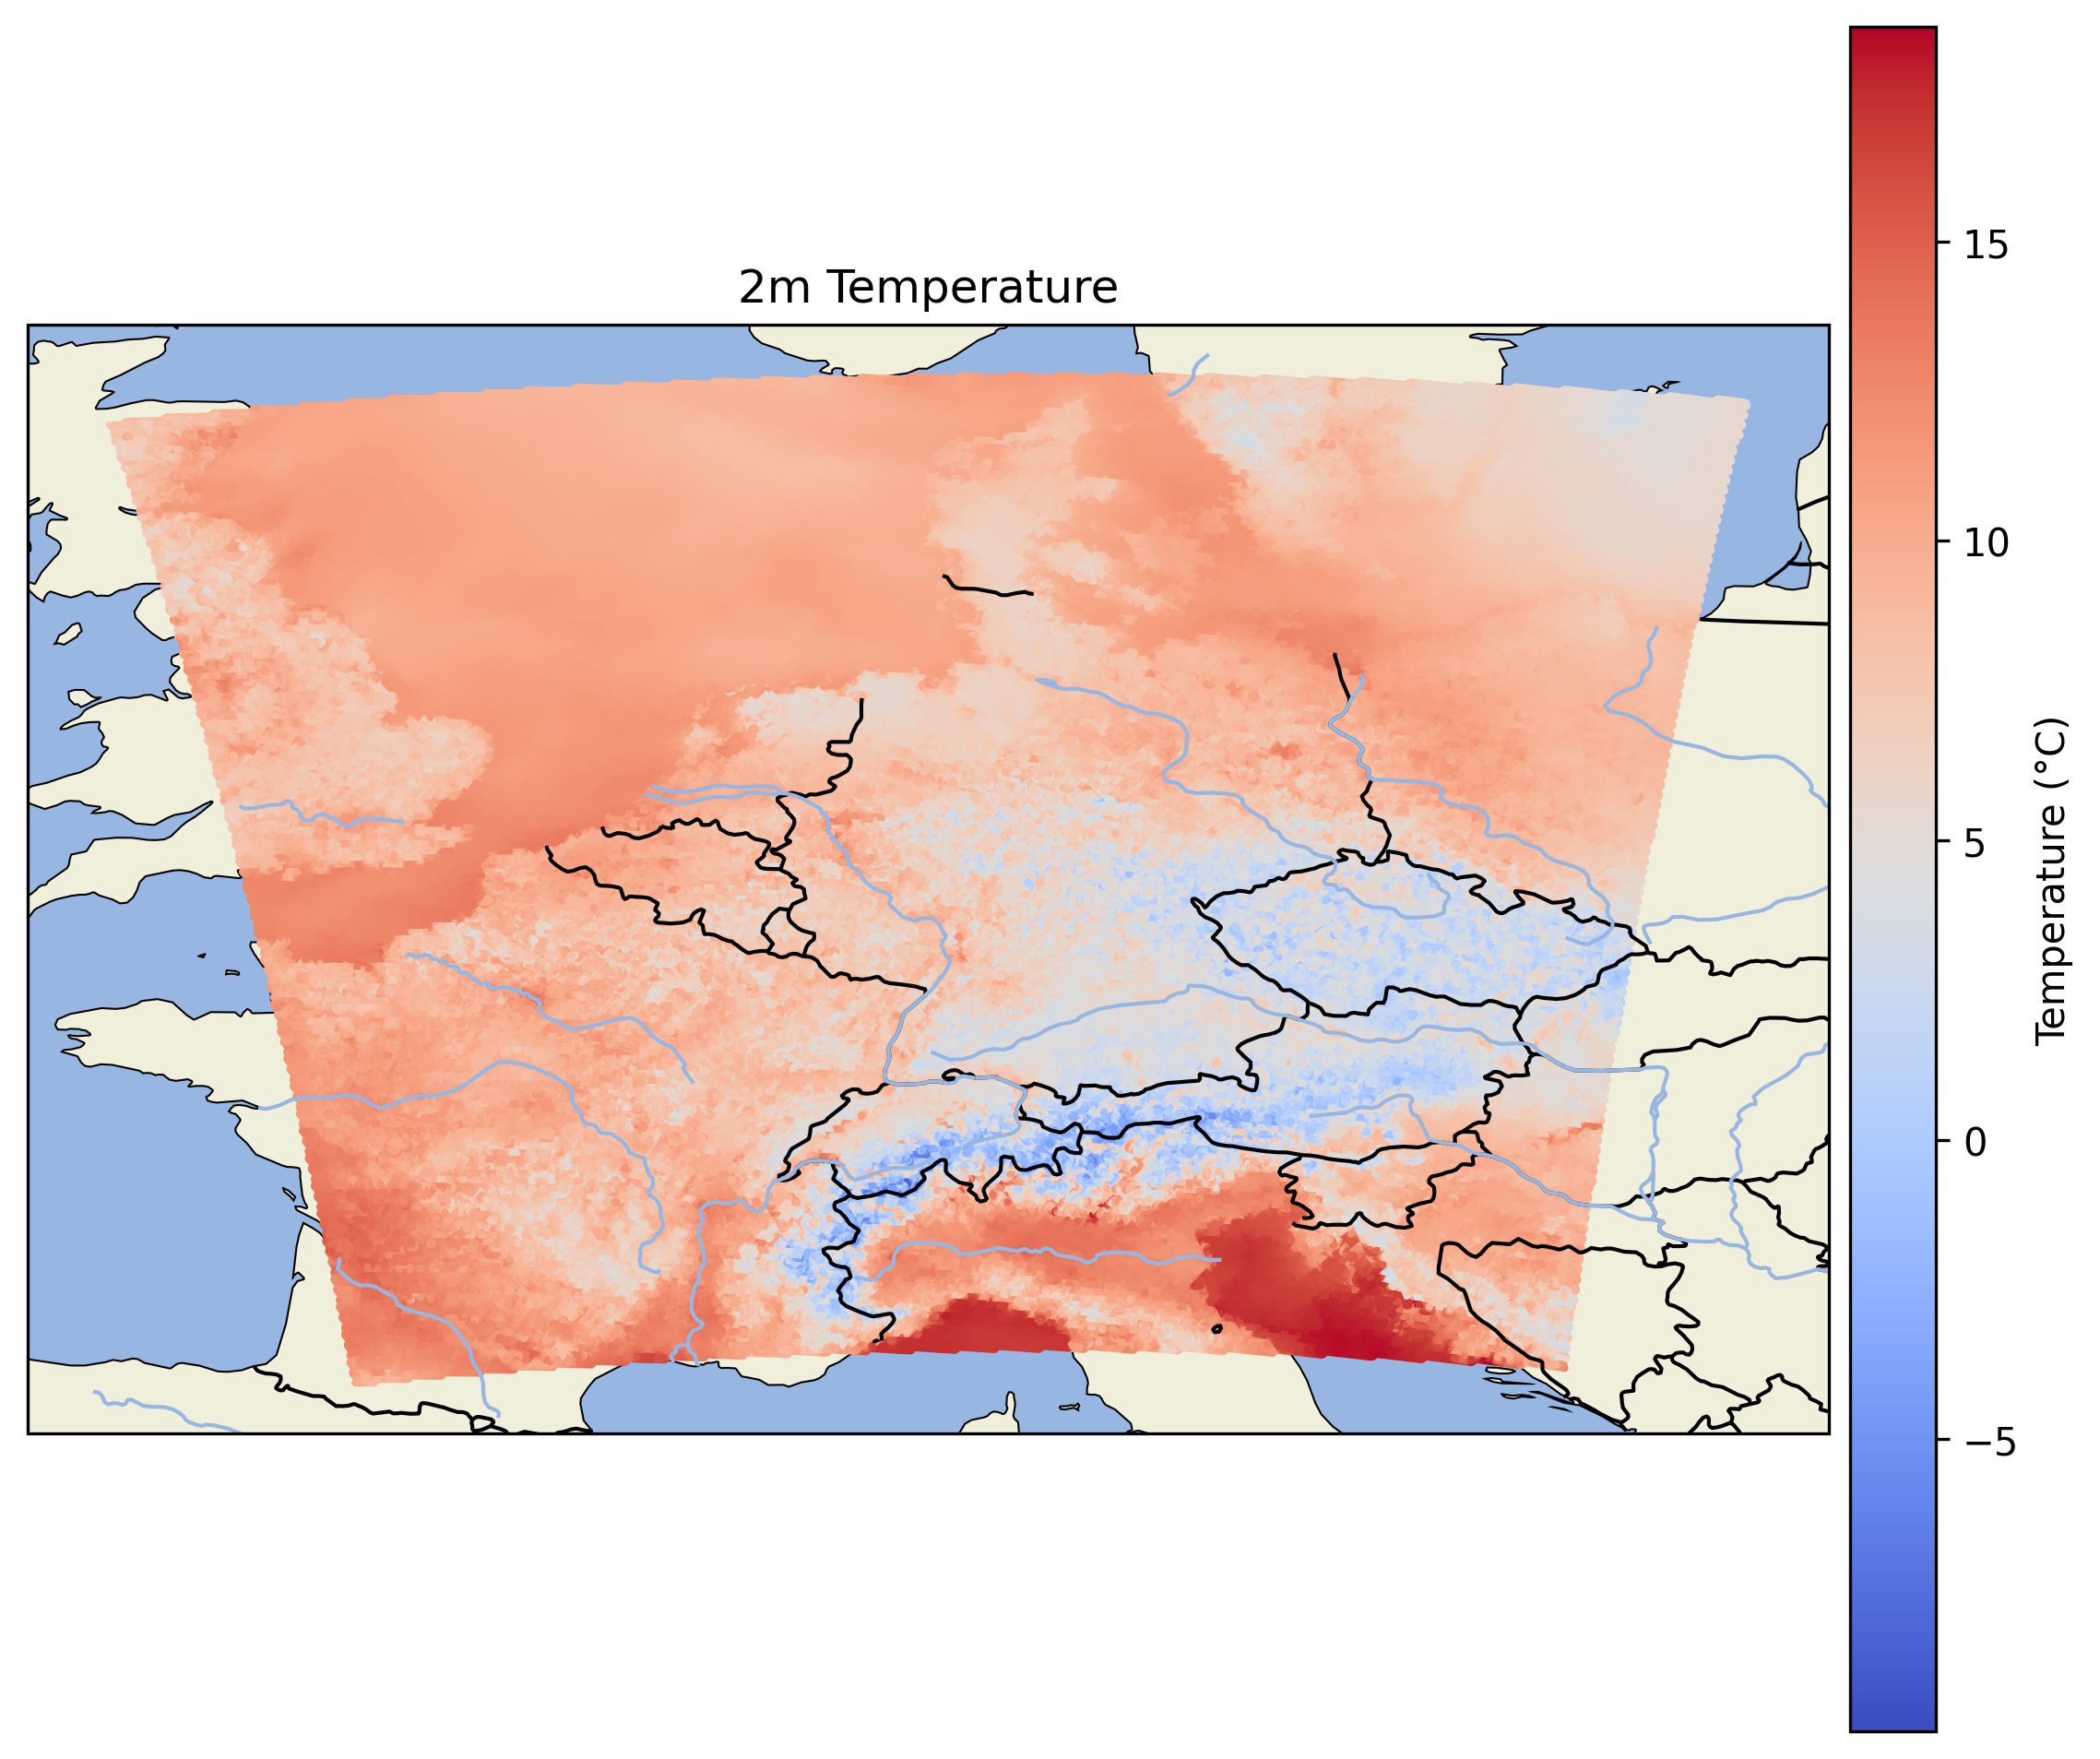

In [13]:
from IPython.display import Image, display
if os.path.exists("t2m.png"):
        display(Image("t2m.png", width=500))

## My own Version of Plotting for Comparison

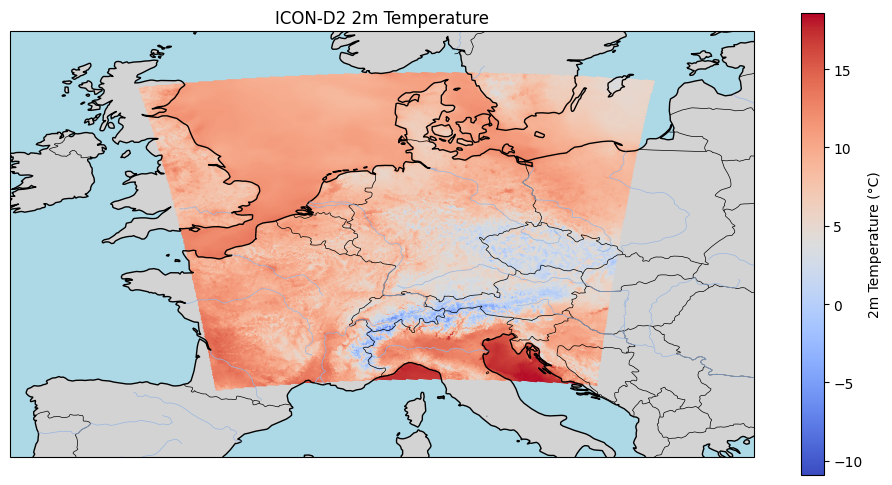

In [14]:
from eccodes import codes_grib_new_from_file, codes_get, codes_get_array, codes_release
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import Image, display
import os

def read_grib_by_shortname(filename, shortname):
    with open(filename, "rb") as f:
        while True:
            gid = codes_grib_new_from_file(f)
            if gid is None:
                break
            if codes_get(gid, "shortName") == shortname:
                values = codes_get_array(gid, "values")
                codes_release(gid)
                return np.array(values)
            codes_release(gid)
    print(f"❌ {shortname} not found in {filename}")
    return None

# Load data with actual shortNames
clat = read_grib_by_shortname("clat.grib2", "tlat")
clon = read_grib_by_shortname("clon.grib2", "tlon")
t2m  = read_grib_by_shortname("data.grib2", "2t")

if clat is None or clon is None or t2m is None:
    print("❌ Failed to load one or more variables.")
else:
    # Convert to Celsius and mask extreme values
    t2m_c = t2m - 273.15
    t2m_c = np.where((t2m_c < -50) | (t2m_c > 50), np.nan, t2m_c)

    # Geographic filter
    mask = (clon >= -10) & (clon <= 50) & (clat >= 30) & (clat <= 75)
    clat = clat[mask]
    clon = clon[mask]
    t2m_c = t2m_c[mask]

    # Plot
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-10, 25, 40, 60], crs=ccrs.PlateCarree())

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

    sc = ax.scatter(clon, clat, c=t2m_c, cmap="coolwarm", s=1, edgecolors='none', transform=ccrs.PlateCarree())
    plt.colorbar(sc, label="2m Temperature (°C)")
    plt.title("ICON-D2 2m Temperature")

    plt.savefig("t2m_template.png", dpi=300, bbox_inches="tight")
    plt.show()